In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_7_1_input_'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.01 # -> 10us

# Solve differential equation from time 0 to time T
T = 400.0 # -> 4000ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 2500
alpha_p = 25.0
beta_p = 25.0

In [6]:
############################################################
#                       Functions                          #
############################################################


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)




# Input

In [19]:

# GABA parameter
sbc_input_intensities = np.linspace(1.0,0.0,8)
gbc_input_intensities = np.linspace(0.0,1.0,8)

adaptor_tone =np.linspace(0,1.0,4)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))



sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)

gauss_mask = gauss(np.linspace(-50,50,10000),0,1)
gauss_mask = gauss_mask/gauss_mask.sum()


############################################################
#                      Simulation                          #
############################################################
s_gbc_all_all = np.zeros((len(adaptor_tone),len(sbc_input_intensities),len(t)))
s_sbc_all_all = np.zeros((len(adaptor_tone),len(sbc_input_intensities),len(t)))
for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        onset = 4000
        s_gbc_all[onset:onset+12000,:] = 0.5+adaptor_tone[l] 
        s_gbc_all[21000:,:] = 1 * gbc_input_strength


#         # create a linearly decreasing function in frequency band 'center_frequencyband'
#         # and smear it with a gauss to effect the neighboring bands
#         gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
#         s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

        
        

        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]
        onset = 4000
        s_sbc_all[onset:onset+12000,:] = 0.5-adaptor_tone[l]
        s_sbc_all[21000:,:] = 1 * sbc_input_strength


#         # create a linearly decreasing function in frequency band 'center_frequencyband'
#         # and smear it with a gauss to effect the neighboring bands
#         sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
#         s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask,axis=0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask,axis=0,mode='constant')

        # correct for border effect of convolve
        s_gbc_all[-2500:,:] = np.max(s_gbc_all[-2500:])
        s_sbc_all[:2500,:] = np.max(s_sbc_all[:2500])
        
        s_gbc_all_all[l,k] = s_gbc_all[:,gbc_center_frequencyBand]
        s_sbc_all_all[l,k] = s_sbc_all[:,sbc_center_frequencyBand]
        


In [22]:
adaptor_tone

array([0.        , 0.33333333, 0.66666667, 1.        ])

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2]


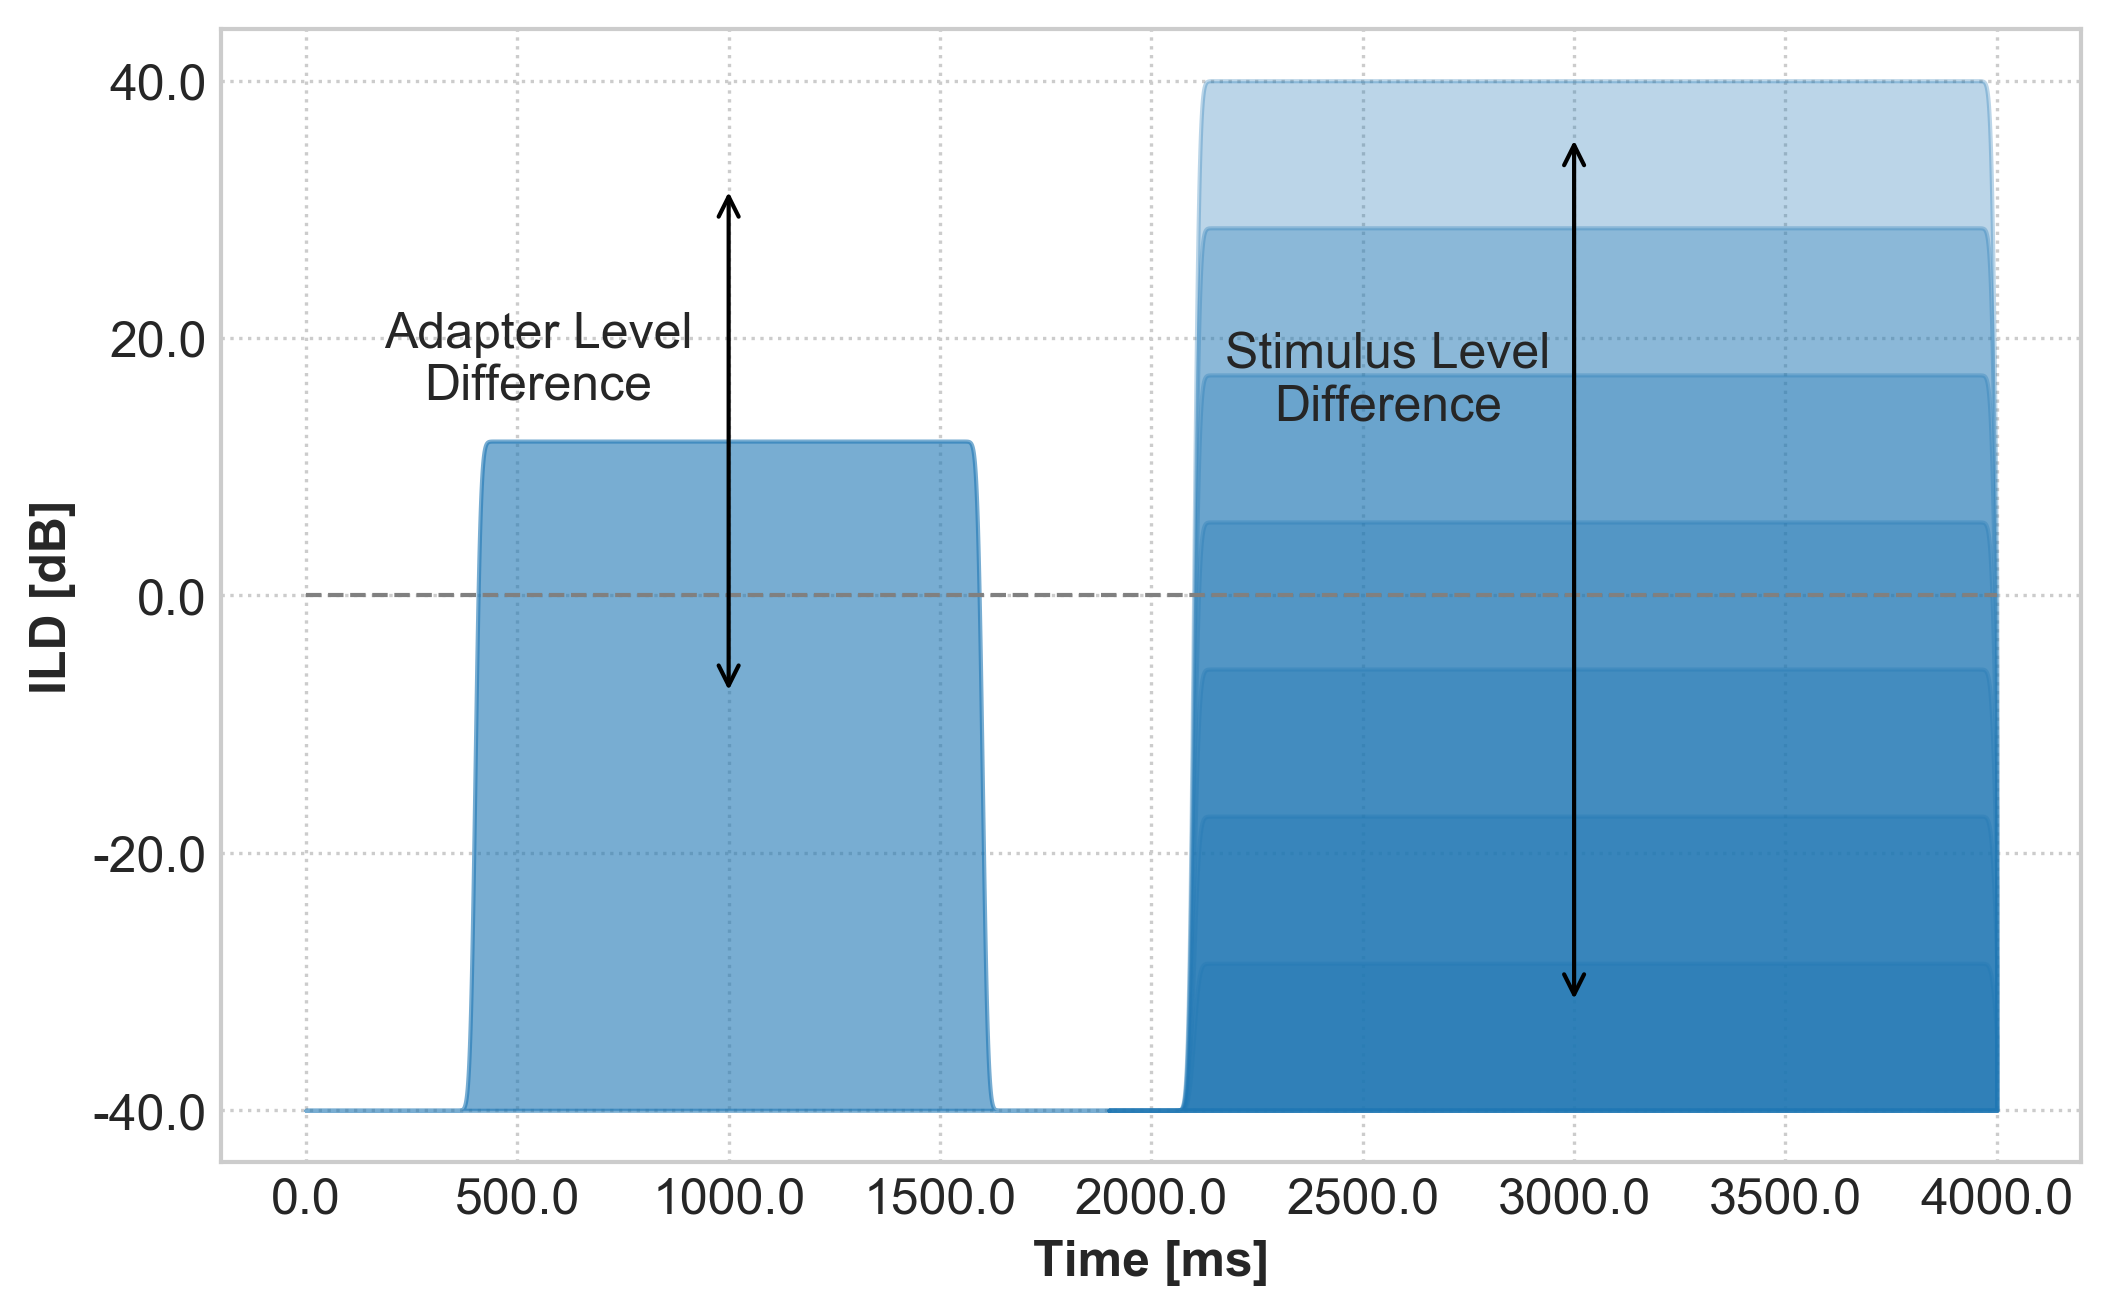

[-50.   0.  50.]


In [35]:
# Define the times when to probe
probing_times = [14000]
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]


# fig = plt.figure(figsize=(10,5))
fig = plt.figure()


plotting_range = np.arange(0,19000)
## show LSO neuron response
ax2 = fig.add_subplot(111)
l = 0
adaptor_levels = [0]
for j in adaptor_levels:
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    l +=1
    for i in range(1,2):
        tmp = s_sbc_all_all[j,i,:]
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
        ax2.fill_between(t[plotting_range]*10,tmp[plotting_range]*1.3, 0, color = face_color, alpha=0.6,label='Adaptor Level : {0:.1f}'.format(adaptor_tone[j]))


plotting_range = np.arange(19000,40000)
## show LSO neuron response
for j in adaptor_levels[::-1]:
    l -=1
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    for i in range(len(sbc_input_intensities)):
        tmp = s_sbc_all_all[j,i,:]

#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color)
        ax2.fill_between(t[plotting_range]*10,tmp[plotting_range], 0, color = face_color,  alpha=0.3)
        
        
ax2.annotate("", xy=(1000, 0.90), xytext=(1000, 0.40),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax2.annotate("Adapter Level\nDifference", xy=(900, 0.66), xytext=(550, 0.68),horizontalalignment='center',verticalalignment='bottom')

ax2.annotate("", xy=(3000, 0.95), xytext=(3000, 0.10),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax2.annotate("Stimulus Level\nDifference", xy=(2560, 0.66), xytext=(2560, 0.66),horizontalalignment='center',verticalalignment='bottom')

ax2.hlines(0.5,0,4000,linestyles='--',linewidth=1,color='grey')


ax2.invert_xaxis()
# plt.title('Input to LSO Neuron')
plt.ylabel('ILD [dB]')
plt.xlabel('Time [ms]')
ax2.set_xticklabels([ float(k ) for k in ax2.get_xticks()])
print(ax2.get_yticks())
# ax2.set_yticks(list(ax2.get_yticks()) + [0.5])
ax2.set_yticks( [0. ,  0.25 , 0.5 , 0.75 , 1. ])
ax2.set_yticklabels(np.linspace(-40,40,len(ax2.get_yticks()),endpoint=True))
ax2.invert_xaxis()
# plt.legend()



plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300


mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']










mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

plt.savefig(figure_name + 'input_stimuli.svg', bbox_inches='tight')
plt.savefig(figure_name + 'input_stimuli.pdf',bbox_inches='tight')
plt.savefig(figure_name + 'input_stimuli.tiff',bbox_inches='tight')
plt.show()


print(np.linspace(-50,50,len(ax2.get_yticks())-2,endpoint=True,))


In [34]:
import dill
dill.dump_session('fig_7_1_dynamic_adaptation_inputs')